CLIP requires strong text encoder and image encoder.

The text encoder is a simple transformer but the image encoder is a ResNet and the ViT transformer.


Zero Shot CLIP has performed better than supervised linear classifier using ResNet.

But the question is : is it useful only for classification.


In [1]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

In [2]:
import numpy as np
import torch
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Load the models

In [3]:
import clip

clip.available_models()

/home/shataxi.dubey/miniconda3/envs/shataxi_space/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/shataxi.dubey/miniconda3/envs/shataxi_space/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

RN50x64
Model parameters: 623,258,305
Input resolution: 448
Context length: 77
Vocab size: 49408

ViT-B/32
Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408

In [4]:
model, preprocess = clip.load('ViT-B/32')
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f42a0e2a520>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch
import glob

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
original_images = []
images = []
texts = []
# region = 'lucknow_airshed_most_15'
# region = 'uttar_pradesh_most_15'
region = 'west_bengal_most_15'

prompt1 = 'A satellite imagery of a brick kiln'
prompt2 = 'brick kiln with chimney'
prompt3 = 'object with chimney'
prompt4 = 'rectangular brick kiln with chimney'
prompt5 = 'rectangular object with chimney'
prompt6 = 'brick kilns'
# superresolution images /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/uttar_pradesh_most_15/swinir_images
image_paths = glob.glob(f'/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/{region}/swinir_images/*')
# image_paths = glob.glob(f'/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/{region}/images/*')
for image in image_paths:
    image = Image.open(image).convert("RGB")
    original_images.append(image)
    images.append(preprocess(image))
    image.save('/home/shataxi.dubey/shataxi_work/vlm_on_planet/tiff_to_png/im.png','PNG') # to store tiff in png format
texts += [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6]



In [8]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [9]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [10]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

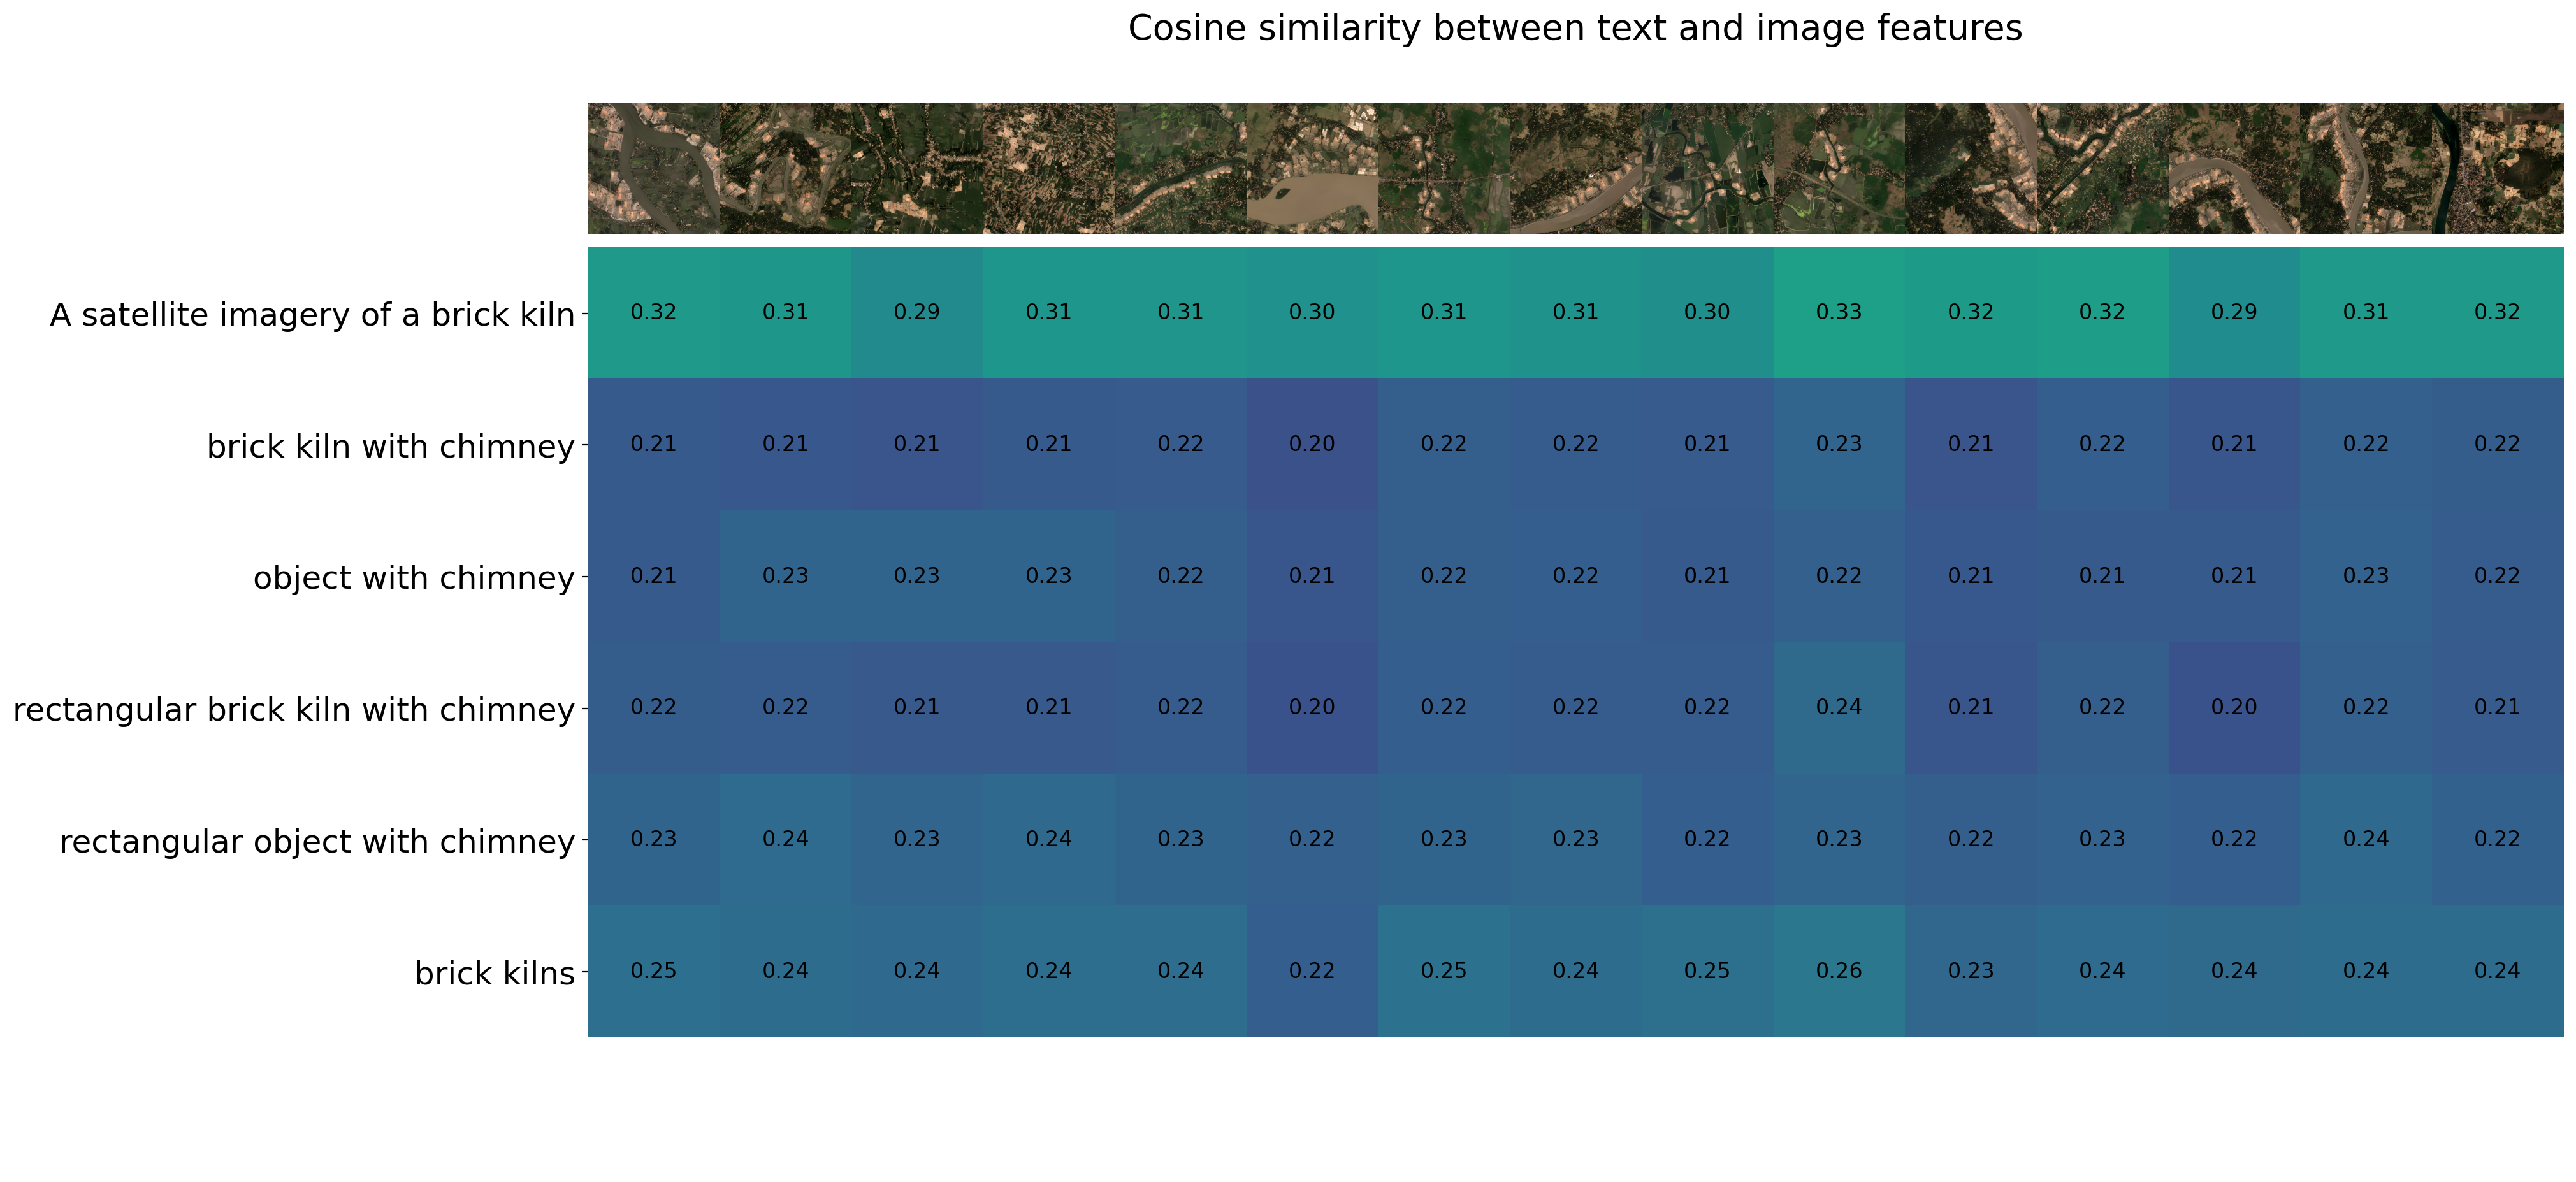

In [11]:
count = len(texts)

plt.figure(figsize=(20, 15))
plt.imshow(similarity, vmin=0.1, vmax=0.5) # vmin and vmax are used to set the colorbar lower and higher limit.

plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6,-0.6), origin="lower") # origin = lower will put the (0,0) pixel of the image in the lower left corner. 
    # extent argument help in plotting multiple images , it takes (xmin, xmax, ymin, ymax), it will start putting the images from -0.5 to 14.5 and all images will be vertically present from -1.6 to 0.6
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, len(original_images) - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)